In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import os

os.environ['CUDA_VISIBLE_DEVICES']="1"

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 9



train_mu = [ 1.,  0.,  -0.5,   0.5,  1.2,  0.3,   -0.4,  0.,  0.8 ]

#train_rho = [ 
#              [0.0, 0.0, 0.1,   -0.1, 0.2, -0.3,     0.5, 0.7],  #0
#              [0.0, -0.1, 0.2,     0.3, 0.4, 0.5,      0.8],  #1
#              [0.0, 0.1, 0.2,   -0.3, -0.6, 0.7],  #2
#              [0.1, -0.3, -0.5,     0.6, -0.8],  #3
#              [-0.1, 0.3, 0.5,   -0.7],  #4
#              [0.0, 0.1, 0.4],  #5
#              [0.1, -0.3],  #6
#              [0.3]  #7
#            ]



train_rho = [ 
              [0., 0., 0.,   0., 0., 0.,     0., 0.],  #0
              [0., 0., 0.,   0., 0., 0.,     0.],  #1
              [0., 0., 0.,   0., 0., 0.],  #2
              [0., 0., 0.,   0., 0.],  #3
              [0., 0., 0.,   0.],  #4
              [0., 0., 0.],  #5
              [0., 0.],  #6
              [0.]  #7
            ]

train_sig = [ 1., 0.7, 1.1,    0.8, 1.3, 0.4,    0.4, 0.7, 1.1 ]





true_mu = [ 0.8,  0.1,  -0.6,   0.3,  1.3,  0.2,   -0.5,  0.2,  0.6 ]


#true_rho  = [ 
#              [0.0, 0.0, 0.1,   -0.1, 0.1, -0.3,     0.5, 0.6],  #0
#              [0.0, -0.1, 0.2,     0.3, 0.4, 0.4,      0.7],  #1
#              [0.0, 0.1, 0.2,   -0.3, -0.5, 0.6],  #2
#              [0.0, -0.3, -0.4,     0.6, -0.7],  #3
#              [-0.1, 0.2, 0.4,   -0.6],  #4
#              [0.0, 0.0, 0.3],  #5
#              [0.0, -0.3],  #6
#              [0.2]  #7
#            ]

true_rho = [ 
              [0., 0., 0.,   0., 0., 0.,     0., 0.],  #0
              [0., 0., 0.,   0., 0., 0.,     0.],  #1
              [0., 0., 0.,   0., 0., 0.],  #2
              [0., 0., 0.,   0., 0.],  #3
              [0., 0., 0.,   0.],  #4
              [0., 0., 0.],  #5
              [0., 0.],  #6
              [0.]  #7
            ]




true_sig = [ 0.8, 0.6, 1.0,    0.6, 1.2, 0.3,    0.3, 0.5, 1.0 ]




resolution = [ 0.4, 0.5, 0.6,   0.3, 0.5, 0.4,   0.6, 0.5, 0.4  ]
#resolution = [ 0.001, 0.001, 0.001,   0.001, 0.001, 0.001,   0.001, 0.001, 0.001  ]




train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                





 Train:
   0,  0 : diagonal    1.0000
   0,  1 : diagonal     1.000 *    0.700 *    0.000 =   0.0000
   0,  2 : diagonal     1.000 *    1.100 *    0.000 =   0.0000
   0,  3 : diagonal     1.000 *    0.800 *    0.000 =   0.0000
   0,  4 : diagonal     1.000 *    1.300 *    0.000 =   0.0000
   0,  5 : diagonal     1.000 *    0.400 *    0.000 =   0.0000
   0,  6 : diagonal     1.000 *    0.400 *    0.000 =   0.0000
   0,  7 : diagonal     1.000 *    0.700 *    0.000 =   0.0000
   0,  8 : diagonal     1.000 *    1.100 *    0.000 =   0.0000
   1,  1 : diagonal    0.4900
   1,  2 : diagonal     0.700 *    1.100 *    0.000 =   0.0000
   1,  3 : diagonal     0.700 *    0.800 *    0.000 =   0.0000
   1,  4 : diagonal     0.700 *    1.300 *    0.000 =   0.0000
   1,  5 : diagonal     0.700 *    0.400 *    0.000 =   0.0000
   1,  6 : diagonal     0.700 *    0.400 *    0.000 =   0.0000
   1,  7 : diagonal     0.700 *    0.700 *    0.000 =   0.0000
   1,  8 : diagonal     0.700 *    1.100 *    0

## Plots to visualize these parameter choices

In [4]:

ngen_train = 400000
ngen_true = 40000

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution)

true_det_pts = np.random.normal( true_pts, resolution)



<function matplotlib.pyplot.show(close=None, block=None)>

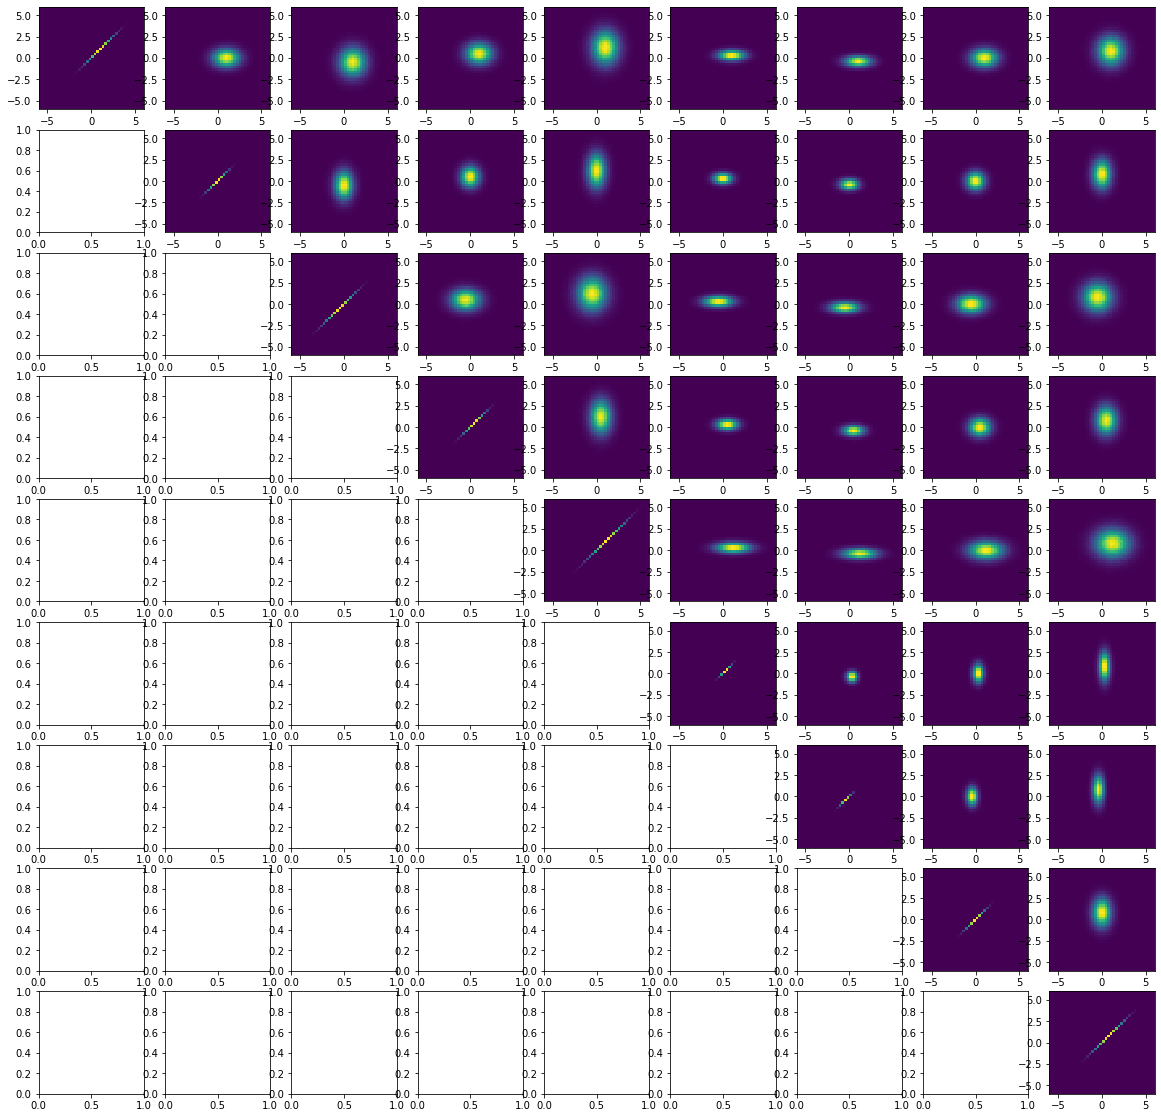

In [5]:
fig,ax = plt.subplots( 9, 9, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

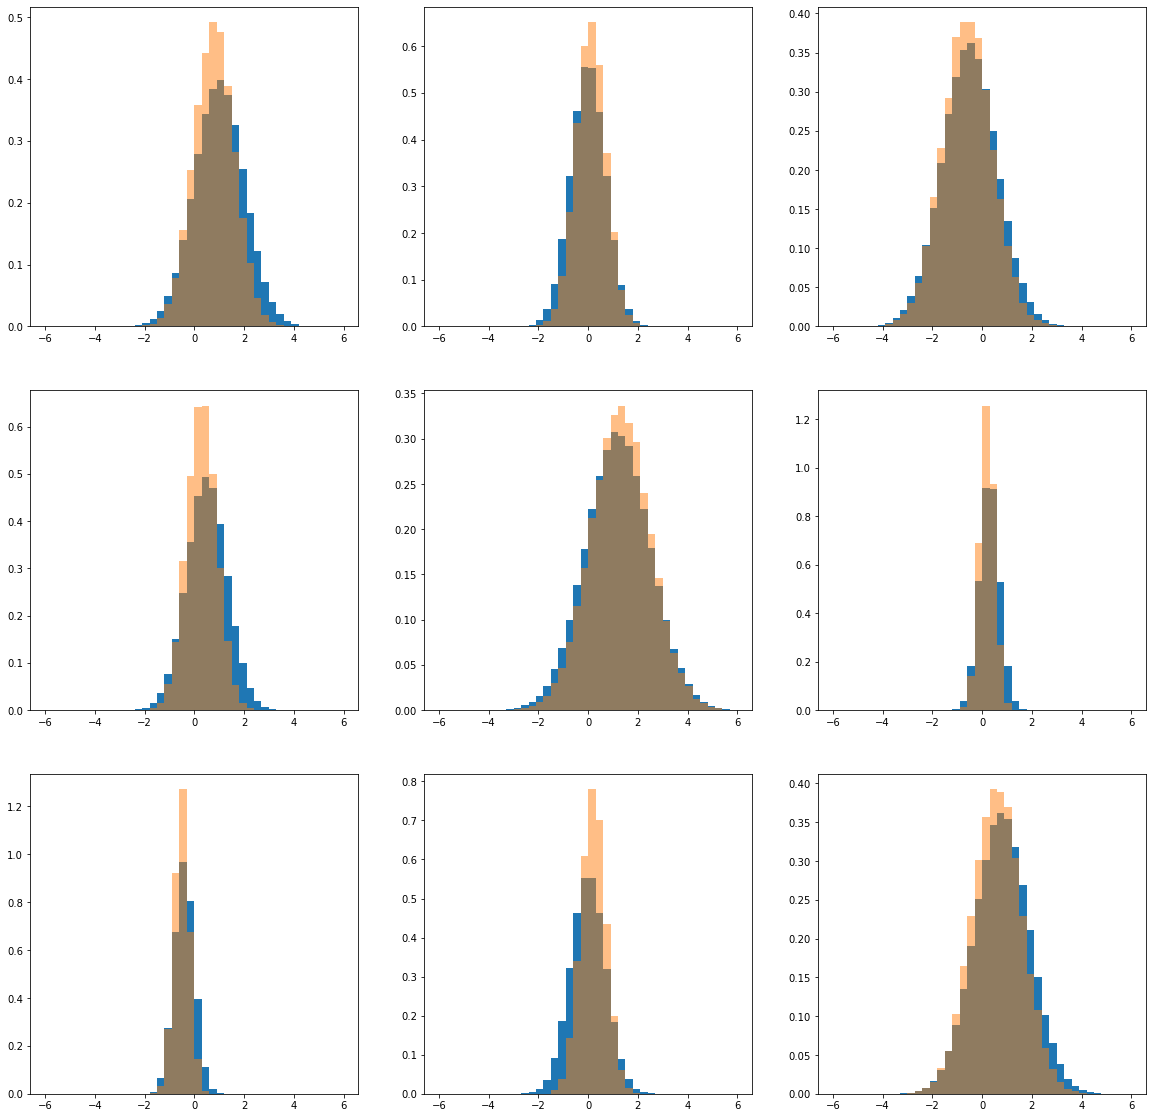

In [6]:
fig,ax = plt.subplots( 3, 3, figsize=(20,20))

hmin=-6
hmax=6
hbins=40


for i in range(3) :
    for j in range(3) :
        k = i*3 + j
        ax[i][j].hist( train_pts[:,k],bins=hbins, range=[hmin,hmax], density=True )
        ax[i][j].hist( true_pts[:,k],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [7]:
inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-11-14 10:34:35.294943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-14 10:34:35.311307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-14 10:34:35.311542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-14 10:34:35.314455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-14 10:34:35.314638: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [8]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [9]:
%%time


verbose = True

#of_niter = 4
of_niter = 10

of_weights = of.omnifold( train_both, true_det_pts, of_niter, model, verbose)




  shape of theta0_S : (400000, 9)
  shape of theta_unknown_S : (40000, 9)
  shape of xvals_1 :  (440000, 9)



  shape of labels0 : (400000,)
  shape of labels_unknown : (40000,)
  shape of yvals_1 :  (440000,)



  shape of theta0_G : (400000, 9)
  shape of xvals_2 :  (800000, 9)
  shape of yvals_2 :  (800000,)




ITERATION: 1

   -- ITERATION 1  STEP 1

Epoch 1/20


2023-11-14 10:34:37.038389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 10:34:37.040123: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9525d386c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 10:34:37.040135: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-14 10:34:37.043661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 10:34:37.126476: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 [==============================] - 2s 7ms/step - loss: 0.4477 - accuracy: 0.4637 - val_loss: 0.3113 - val_accuracy: 0.4545
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.2997 - accuracy: 0.4545 - val_loss: 0.2910 - val_accuracy: 0.4545
Epoch 3/20
33/33 [==============================] - 0s 3ms/step - loss: 0.2893 - accuracy: 0.4545 - val_loss: 0.2872 - val_accuracy: 0.4545
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 0.2869 - accuracy: 0.4545 - val_loss: 0.2854 - val_accuracy: 0.4545
Epoch 5/20
33/33 [==============================] - 0s 3ms/step - loss: 0.2853 - accuracy: 0.4545 - val_loss: 0.2842 - val_accuracy: 0.4545
Epoch 6/20
33/33 [==============================] - 0s 2ms/step - loss: 0.2843 - accuracy: 0.4545 - val_loss: 0.2834 - val_accuracy: 0.4545
Epoch 7/20
33/33 [==============================] - 0s 3ms/step - loss: 0.2835 - accuracy: 0.4545 - val_loss: 0.2830 - val_accuracy: 0.4545
Epoch 8/20
33/33 [=============

33/33 [==============================] - 0s 3ms/step - loss: 0.1215 - accuracy: 0.3462 - val_loss: 0.1224 - val_accuracy: 0.3381
Epoch 18/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.3473 - val_loss: 0.1224 - val_accuracy: 0.3434
Epoch 19/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.3484 - val_loss: 0.1224 - val_accuracy: 0.3298
Epoch 20/20
40/40 [==============================] - 0s 621us/step

   -- ITERATION 2  STEP 2

Epoch 1/20
300/300 [==============================] - 2s 3ms/step - loss: 0.1591 - accuracy: 0.2516 - val_loss: 0.1529 - val_accuracy: 0.2502
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1527 - accuracy: 0.2499 - val_loss: 0.1528 - val_accuracy: 0.2502
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1527 - accuracy: 0.2499 - val_loss: 0.1528 - val_accuracy: 0.2502
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - 

300/300 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1520 - val_accuracy: 0.2499
Epoch 13/20
300/300 [==============================] - 1s 2ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1520 - val_accuracy: 0.2499
Epoch 14/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1520 - val_accuracy: 0.2499
Epoch 15/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1520 - val_accuracy: 0.2499
Epoch 16/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1520 - val_accuracy: 0.2499
Epoch 17/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1521 - val_accuracy: 0.2499
Epoch 18/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.2500 - val_loss: 0.1520 - val_accuracy: 0.2499
Epoch 19/20

33/33 [==============================] - 0s 3ms/step - loss: 0.1268 - accuracy: 0.3491 - val_loss: 0.1275 - val_accuracy: 0.3547
Epoch 8/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1268 - accuracy: 0.3406 - val_loss: 0.1275 - val_accuracy: 0.3369
Epoch 9/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.3481 - val_loss: 0.1275 - val_accuracy: 0.3232
Epoch 10/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.3428 - val_loss: 0.1275 - val_accuracy: 0.3361
Epoch 11/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.3464 - val_loss: 0.1275 - val_accuracy: 0.3456
Epoch 12/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.3456 - val_loss: 0.1275 - val_accuracy: 0.3328
Epoch 13/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.3463 - val_loss: 0.1275 - val_accuracy: 0.3408
Epoch 14/20
33/33 [========

300/300 [==============================] - 1s 2ms/step - loss: 0.1491 - accuracy: 0.2496 - val_loss: 0.1488 - val_accuracy: 0.2511
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.2496 - val_loss: 0.1489 - val_accuracy: 0.2511
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.2496 - val_loss: 0.1489 - val_accuracy: 0.2511
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.2496 - val_loss: 0.1490 - val_accuracy: 0.2511
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.2496 - val_loss: 0.1489 - val_accuracy: 0.2511
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1490 - accuracy: 0.2496 - val_loss: 0.1490 - val_accuracy: 0.2511
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.2496 - val_loss: 0.1490 - val_accuracy: 0.2511
Epoch 9/20
300/30

300/300 [==============================] - 1s 3ms/step - loss: 0.1461 - accuracy: 0.2500 - val_loss: 0.1463 - val_accuracy: 0.2501
Epoch 19/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1461 - accuracy: 0.2500 - val_loss: 0.1464 - val_accuracy: 0.2501
Epoch 20/20
40/40 [==============================] - 0s 770us/step

ITERATION: 8

   -- ITERATION 8  STEP 1

Epoch 1/20
33/33 [==============================] - 1s 6ms/step - loss: 0.1678 - accuracy: 0.4408 - val_loss: 0.1299 - val_accuracy: 0.3433
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.2917 - val_loss: 0.1288 - val_accuracy: 0.3628
Epoch 3/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.3510 - val_loss: 0.1286 - val_accuracy: 0.3331
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1282 - accuracy: 0.3403 - val_loss: 0.1286 - val_accuracy: 0.3334
Epoch 5/20
33/33 [==============================] - 0s 4m

Epoch 14/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.2773 - val_loss: 0.1252 - val_accuracy: 0.2991
Epoch 15/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.2873 - val_loss: 0.1252 - val_accuracy: 0.2886
Epoch 16/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.2922 - val_loss: 0.1252 - val_accuracy: 0.3069
Epoch 17/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.2822 - val_loss: 0.1252 - val_accuracy: 0.3006
Epoch 18/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.2925 - val_loss: 0.1252 - val_accuracy: 0.2771
Epoch 19/20
33/33 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.2869 - val_loss: 0.1252 - val_accuracy: 0.2878
Epoch 20/20
40/40 [==============================] - 0s 633us/step

   -- ITERATION 9  STEP 2

Epoch 1/20
300/300 [==============================] - 2s 3m

300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1455 - val_accuracy: 0.2506
Epoch 10/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1455 - val_accuracy: 0.2506
Epoch 11/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1456 - val_accuracy: 0.2506
Epoch 12/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1456 - val_accuracy: 0.2506
Epoch 13/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1457 - val_accuracy: 0.2506
Epoch 14/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1456 - val_accuracy: 0.2506
Epoch 15/20
300/300 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.2498 - val_loss: 0.1456 - val_accuracy: 0.2506
Epoch 16/20

In [10]:
np.shape( of_weights)

(10, 2, 400000)

<function matplotlib.pyplot.show(close=None, block=None)>

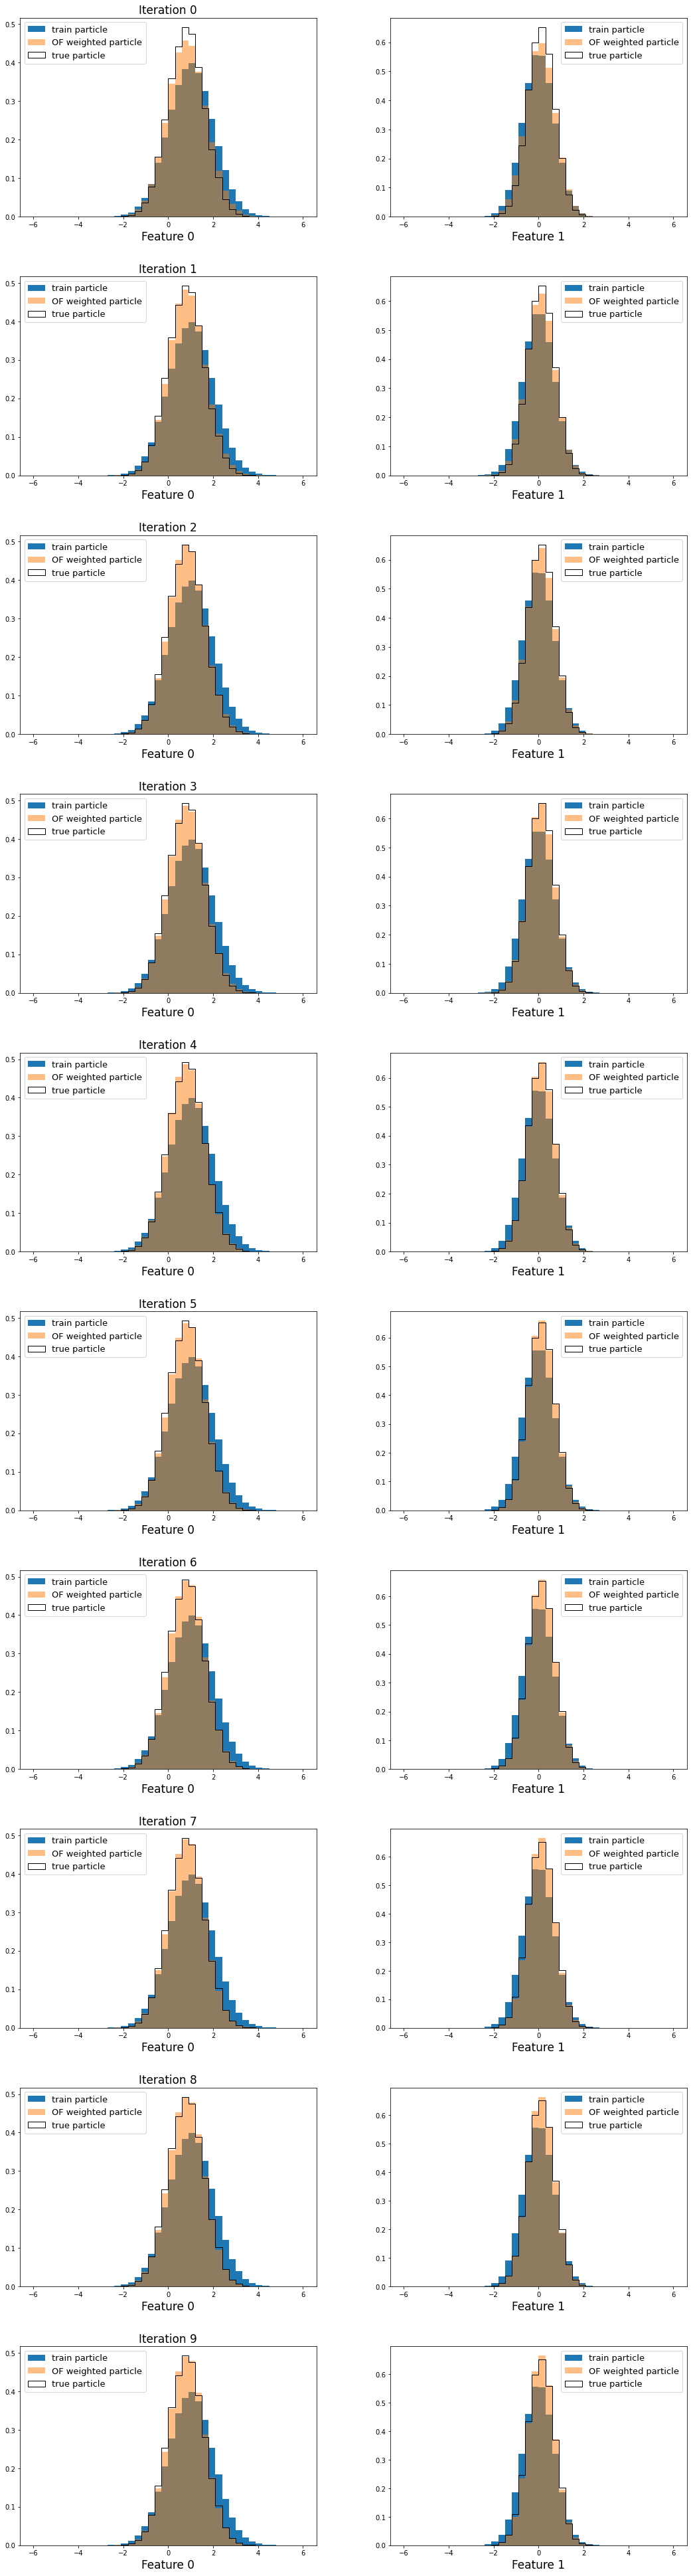

In [11]:


fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)



for ofi in range(0,of_niter) :

    ax[ofi][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][0].hist( train_pts[:,0], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )

    ax[ofi][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][1].hist( train_pts[:,1], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )


    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

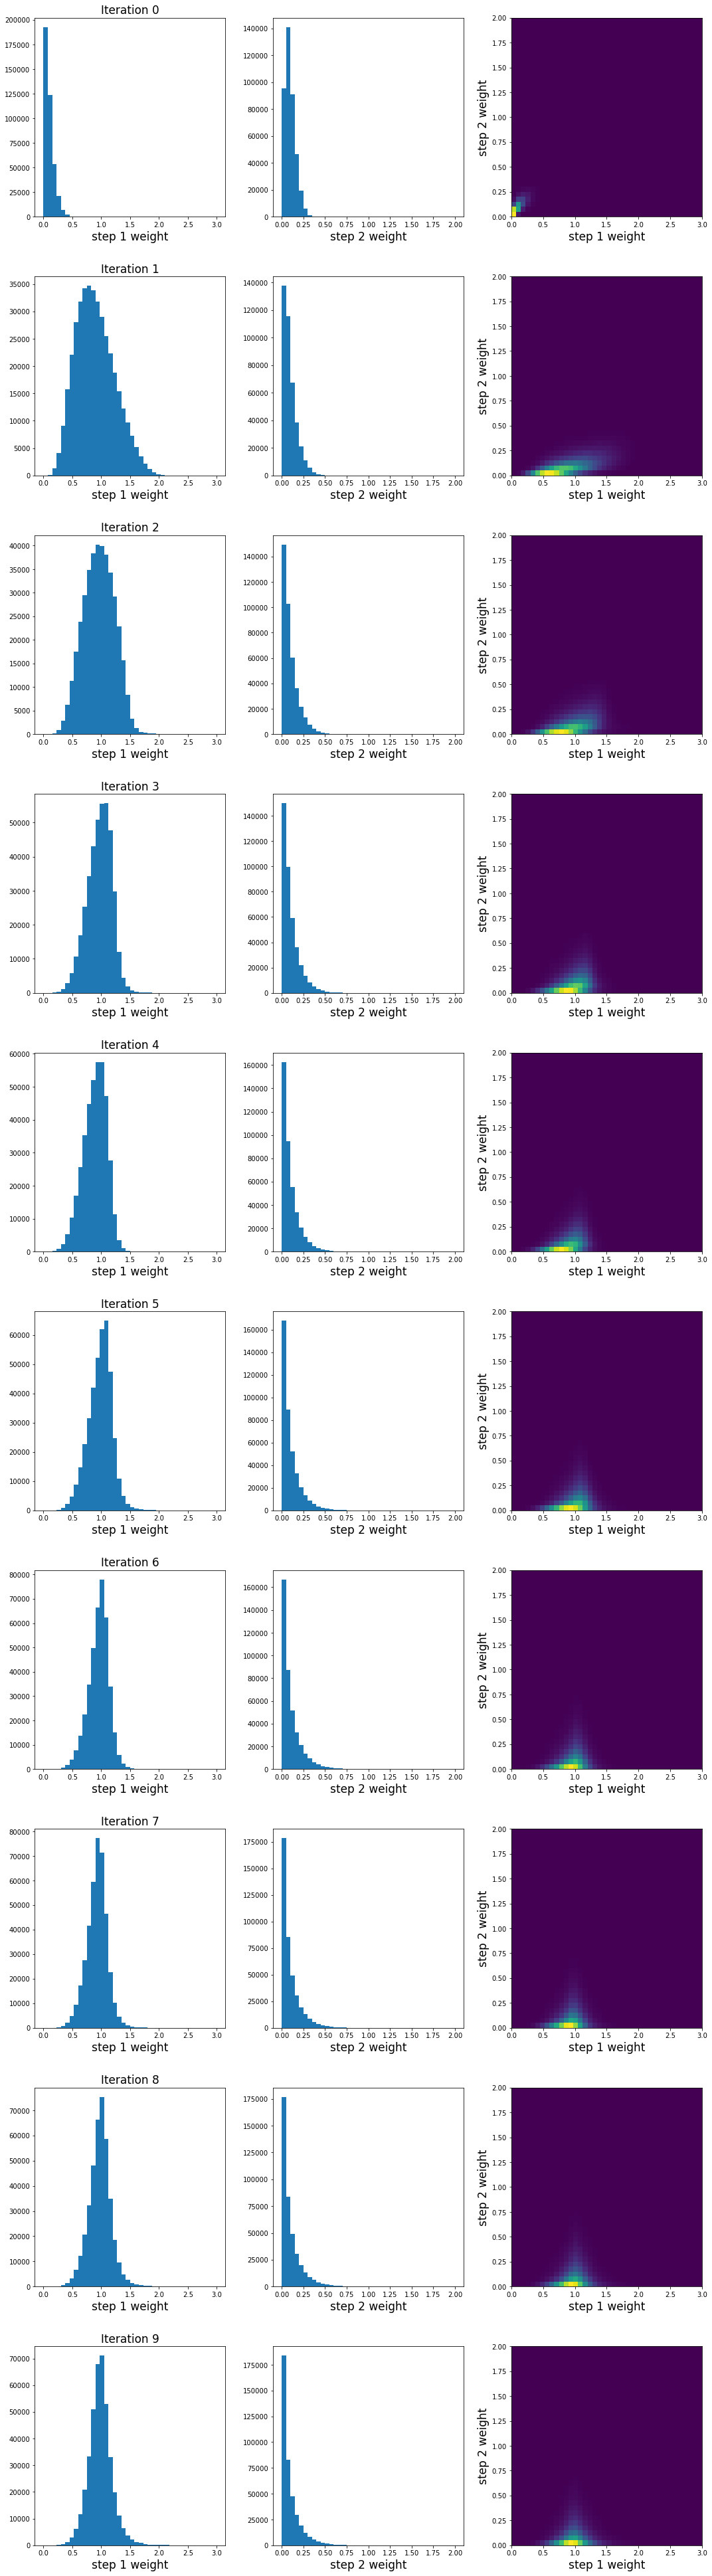

In [12]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0,3] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0,2] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins], range=([0,3],[0,2]) )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

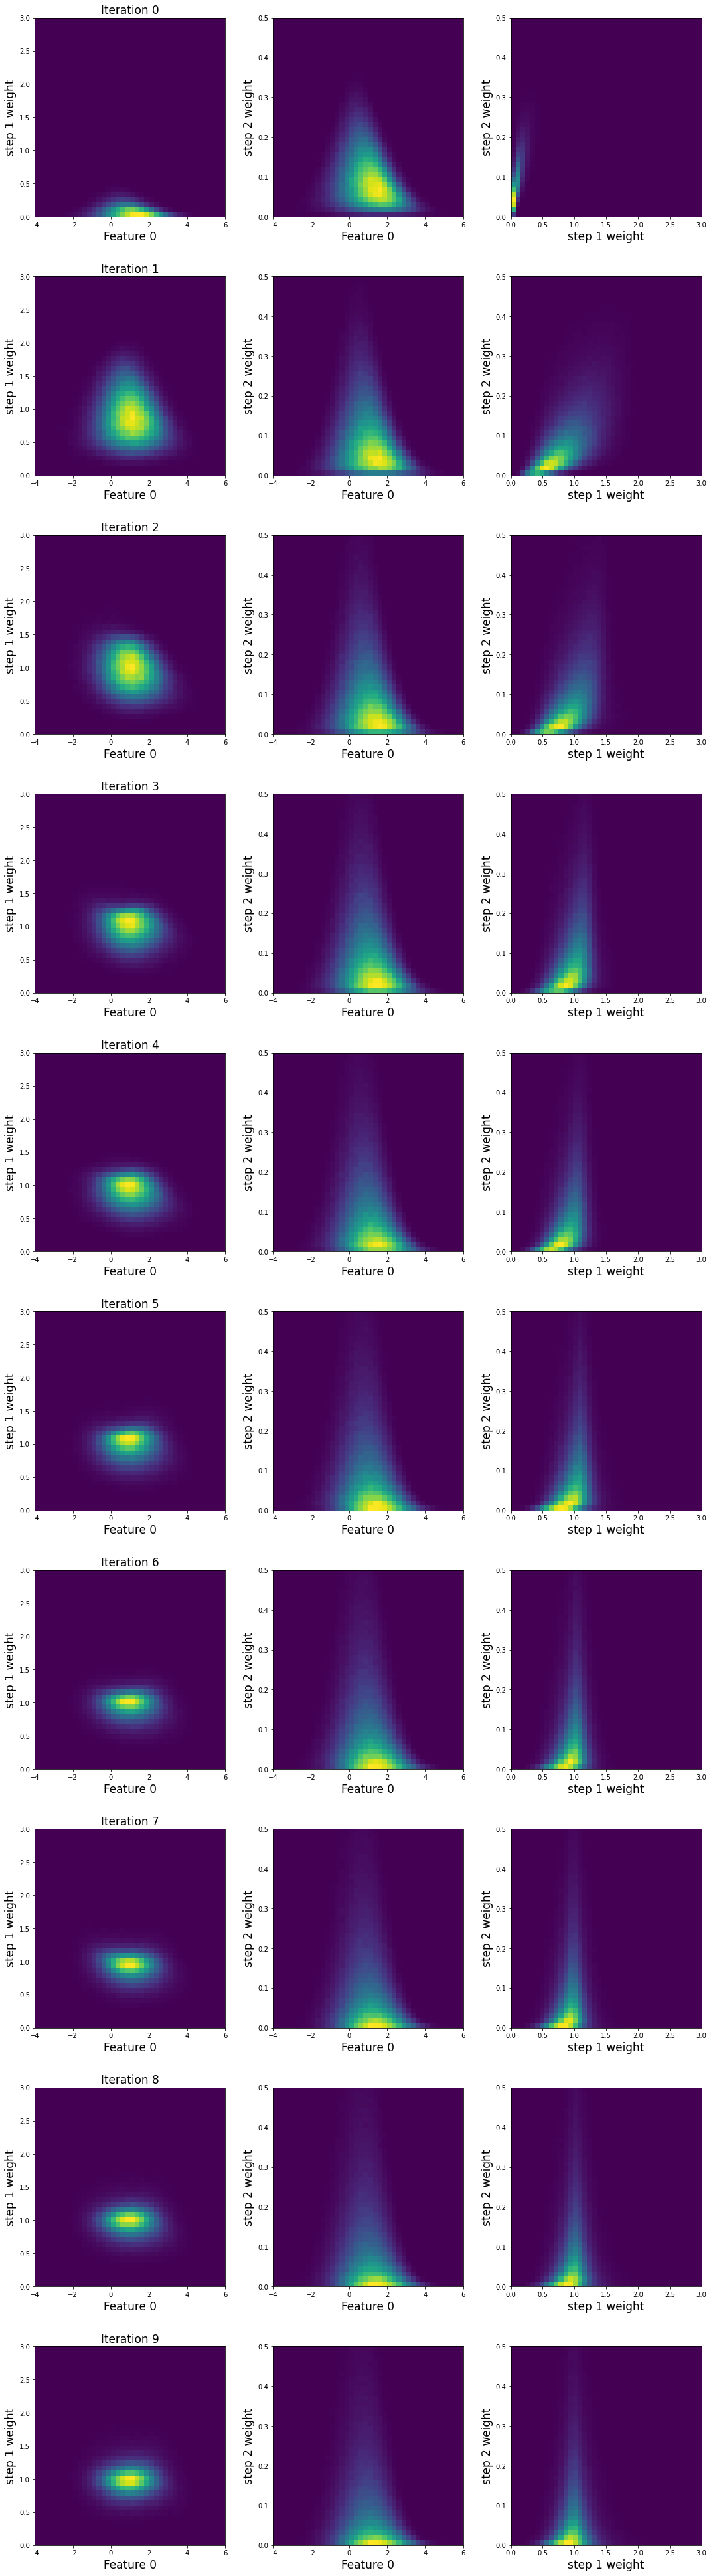

In [13]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,0], of_weights[ofi,0,:], bins=[hbins,hbins], range=([-4,6],[0,3]) )
    ax[ofi][1].hist2d( train_pts[:,0], of_weights[ofi,1,:], bins=[hbins,hbins], range=([-4,6],[0,0.5]) )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins], range=([0,3],[0,0.5]) )
    
    ax[ofi][0].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [14]:
max_step2_weight = np.max( of_weights[of_niter-1,1,:] )

<function matplotlib.pyplot.show(close=None, block=None)>

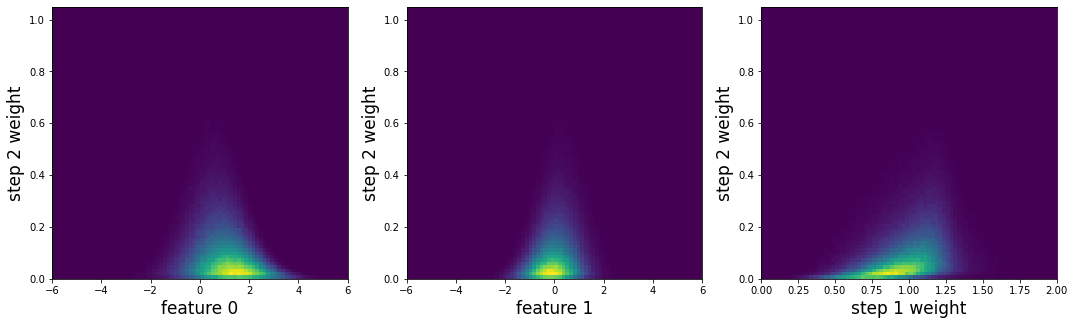

In [15]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))

hmin=-6
hmax=6
hbins=80

ax[0].hist2d( train_pts[:,0], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[1].hist2d( train_pts[:,1], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[2].hist2d( of_weights[3,0,:], of_weights[3,1,:], bins=[hbins,hbins], range=([0.,2.],[0.,1.1*max_step2_weight]))


lfontsize = 17

ax[0].set_xlabel( 'feature 0', fontsize=lfontsize )
ax[0].set_ylabel( 'step 2 weight', fontsize=lfontsize )


ax[1].set_xlabel( 'feature 1', fontsize=lfontsize )
ax[1].set_ylabel( 'step 2 weight', fontsize=lfontsize )

ax[2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
ax[2].set_ylabel( 'step 2 weight', fontsize=lfontsize )


plt.show


## Do the bootstrap samples in a loop

In [16]:
n_boot_samples = 50

do_bootstrap = True

verbose = False

bootstrap_weights = np.zeros( shape=(n_boot_samples, len(train_pts) ))

In [17]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        
    boot_of_weights = of.omnifold( train_both, boot_true_det_pts, of_niter, model, verbose)
    
    bootstrap_weights[bi] = boot_of_weights[(of_niter-1),1,:]
    


 Creating bootstrap sample   0
40/40 [==============================] - 0s 724us/step

 Creating bootstrap sample   1
40/40 [==============================] - 0s 680us/step

 Creating bootstrap sample   2
40/40 [==============================] - 0s 712us/step

 Creating bootstrap sample   3
40/40 [==============================] - 0s 682us/step

 Creating bootstrap sample   4
40/40 [==============================] - 0s 706us/step


40/40 [==============================] - 0s 735us/step

 Creating bootstrap sample   5
40/40 [==============================] - 0s 700us/step

 Creating bootstrap sample   6
40/40 [==============================] - 0s 669us/step

 Creating bootstrap sample   7
40/40 [==============================] - 0s 700us/step

 Creating bootstrap sample   8
40/40 [==============================] - 0s 738us/step

 Creating bootstrap sample   9
40/40 [==============================] - 0s 726us/step


40/40 [==============================] - 0s 732us/step

 Creating bootstrap sample  10
40/40 [==============================] - 0s 748us/step

 Creating bootstrap sample  11
40/40 [==============================] - 0s 695us/step

 Creating bootstrap sample  12
40/40 [==============================] - 0s 654us/step

 Creating bootstrap sample  13
40/40 [==============================] - 0s 720us/step

 Creating bootstrap sample  14
40/40 [==============================] - 0s 753us/step


40/40 [==============================] - 0s 736us/step

 Creating bootstrap sample  15
40/40 [==============================] - 0s 710us/step

 Creating bootstrap sample  16
40/40 [==============================] - 0s 711us/step

 Creating bootstrap sample  17
40/40 [==============================] - 0s 686us/step

 Creating bootstrap sample  18
40/40 [==============================] - 0s 711us/step

 Creating bootstrap sample  19
40/40 [==============================] - 0s 708us/step


40/40 [==============================] - 0s 765us/step

 Creating bootstrap sample  20
40/40 [==============================] - 0s 719us/step

 Creating bootstrap sample  21
40/40 [==============================] - 0s 660us/step

 Creating bootstrap sample  22
40/40 [==============================] - 0s 691us/step

 Creating bootstrap sample  23
40/40 [==============================] - 0s 698us/step

 Creating bootstrap sample  24
40/40 [==============================] - 0s 695us/step


40/40 [==============================] - 0s 713us/step

 Creating bootstrap sample  25
40/40 [==============================] - 0s 748us/step

 Creating bootstrap sample  26
40/40 [==============================] - 0s 703us/step

 Creating bootstrap sample  27
40/40 [==============================] - 0s 710us/step

 Creating bootstrap sample  28
40/40 [==============================] - 0s 717us/step

 Creating bootstrap sample  29
40/40 [==============================] - 0s 703us/step


40/40 [==============================] - 0s 697us/step

 Creating bootstrap sample  30
40/40 [==============================] - 0s 695us/step

 Creating bootstrap sample  31
40/40 [==============================] - 0s 713us/step

 Creating bootstrap sample  32
40/40 [==============================] - 0s 705us/step

 Creating bootstrap sample  33
40/40 [==============================] - 0s 668us/step

 Creating bootstrap sample  34
40/40 [==============================] - 0s 631us/step


40/40 [==============================] - 0s 718us/step

 Creating bootstrap sample  35
40/40 [==============================] - 0s 738us/step

 Creating bootstrap sample  36
40/40 [==============================] - 0s 741us/step

 Creating bootstrap sample  37
40/40 [==============================] - 0s 680us/step

 Creating bootstrap sample  38
40/40 [==============================] - 0s 679us/step


40/40 [==============================] - 0s 676us/step

 Creating bootstrap sample  39
40/40 [==============================] - 0s 719us/step

 Creating bootstrap sample  40
40/40 [==============================] - 0s 720us/step

 Creating bootstrap sample  41
40/40 [==============================] - 0s 692us/step

 Creating bootstrap sample  42
40/40 [==============================] - 0s 737us/step

 Creating bootstrap sample  43
40/40 [==============================] - 0s 679us/step


40/40 [==============================] - 0s 736us/step

 Creating bootstrap sample  44
40/40 [==============================] - 0s 682us/step

 Creating bootstrap sample  45
40/40 [==============================] - 0s 713us/step

 Creating bootstrap sample  46
40/40 [==============================] - 0s 704us/step

 Creating bootstrap sample  47
40/40 [==============================] - 0s 726us/step

 Creating bootstrap sample  48
40/40 [==============================] - 0s 674us/step


40/40 [==============================] - 0s 712us/step

 Creating bootstrap sample  49
40/40 [==============================] - 0s 705us/step
CPU times: user 3h 28min 52s, sys: 12min 53s, total: 3h 41min 46s
Wall time: 2h 33min 28s


In [18]:
bootstrap_weights

array([[0.05825846, 0.00444955, 0.03938199, ..., 0.0105007 , 0.2651993 ,
        0.13181777],
       [0.08582669, 0.01145625, 0.01765387, ..., 0.00134041, 0.30778998,
        0.12308044],
       [0.10842548, 0.00644783, 0.04220739, ..., 0.00238085, 0.31157064,
        0.10876457],
       ...,
       [0.05609452, 0.0171862 , 0.02683219, ..., 0.00033051, 0.20904326,
        0.10039526],
       [0.07841862, 0.01780036, 0.02446106, ..., 0.01191623, 0.24608339,
        0.10663573],
       [0.07524089, 0.01588428, 0.02323137, ..., 0.00223302, 0.21525036,
        0.0911767 ]])

In [19]:
of_weights[3,1,:]

array([0.14293835, 0.03718949, 0.02681052, ..., 0.00887751, 0.19006109,
       0.13833876])

In [20]:
bootstrap_weights[0]

array([0.05825846, 0.00444955, 0.03938199, ..., 0.0105007 , 0.2651993 ,
       0.13181777])

In [21]:
np.cov( bootstrap_weights[:,0])

array(0.0031518)

In [22]:
bootstrap_weights[:,100]

array([0.00767948, 0.01856924, 0.01048553, 0.004122  , 0.01069824,
       0.00596506, 0.00553721, 0.01389798, 0.01377622, 0.00457247,
       0.00545386, 0.00948929, 0.01676548, 0.02024555, 0.03265021,
       0.01829587, 0.03267808, 0.00369064, 0.0089312 , 0.00879924,
       0.01292324, 0.01036378, 0.01737748, 0.01283719, 0.01452963,
       0.00968731, 0.02566234, 0.03022011, 0.01898856, 0.01147857,
       0.01654571, 0.01274798, 0.02854796, 0.03274866, 0.04157036,
       0.02302341, 0.00485434, 0.00277751, 0.01199097, 0.01119634,
       0.01145569, 0.00935759, 0.00698663, 0.00717562, 0.00638002,
       0.03392322, 0.01765783, 0.02011975, 0.0155587 , 0.00738748])

<function matplotlib.pyplot.show(close=None, block=None)>

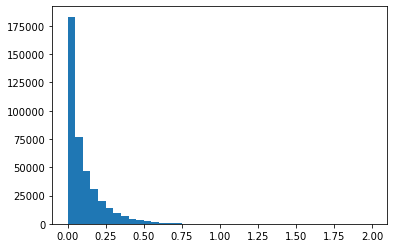

In [23]:
plt.hist( bootstrap_weights[1,:], bins=40, range=[0,2])
plt.show

In [24]:
np.mean( bootstrap_weights, axis=0 )

array([0.13887967, 0.00973043, 0.01850994, ..., 0.00893357, 0.22152811,
       0.12430268])

In [25]:
bootstrap_w2 = bootstrap_weights * bootstrap_weights

In [26]:
bootstrap_w2

array([[3.39404848e-03, 1.97984750e-05, 1.55094130e-03, ...,
        1.10264685e-04, 7.03306706e-02, 1.73759253e-02],
       [7.36622157e-03, 1.31245584e-04, 3.11659041e-04, ...,
        1.79670327e-06, 9.47346726e-02, 1.51487947e-02],
       [1.17560854e-02, 4.15745208e-05, 1.78146409e-03, ...,
        5.66843244e-06, 9.70762664e-02, 1.18297325e-02],
       ...,
       [3.14659473e-03, 2.95365351e-04, 7.19966289e-04, ...,
        1.09235203e-07, 4.36990864e-02, 1.00792087e-02],
       [6.14947995e-03, 3.16852981e-04, 5.98343402e-04, ...,
        1.41996437e-04, 6.05570367e-02, 1.13711799e-02],
       [5.66119118e-03, 2.52310298e-04, 5.39696656e-04, ...,
        4.98638365e-06, 4.63327166e-02, 8.31319127e-03]])

In [27]:
bootstrap_variance = np.mean( bootstrap_w2, axis=0 ) - np.mean( bootstrap_weights, axis=0 ) * np.mean( bootstrap_weights, axis=0 )

In [28]:
bootstrap_variance

array([3.08875926e-03, 9.28996365e-05, 1.03041921e-04, ...,
       1.32953806e-04, 1.76003125e-03, 4.95427091e-04])

In [29]:
bootstrap_rms = np.sqrt( bootstrap_variance )

In [30]:
bootstrap_rms

array([0.05557661, 0.00963845, 0.01015096, ..., 0.01153056, 0.04195273,
       0.02225819])

In [31]:
bootstrap_weights.shape

(50, 400000)

In [32]:
bootstrap_weights.T.shape

(400000, 50)

In [33]:
bootstrap_weights_dot = np.dot( bootstrap_weights, bootstrap_weights.T )

In [34]:
bootstrap_weights_dot

array([[ 22186.20585477,   9297.16044299,   8447.66026514, ...,
          7897.22341075,   8327.04197218,   8052.67986082],
       [  9297.16044299, 670949.74141537,   8971.51437822, ...,
          8019.12315369,   8480.3274519 ,   8127.43504969],
       [  8447.66026514,   8971.51437822, 146844.7488416 , ...,
          7577.38419115,   8012.26537772,   7684.17853077],
       ...,
       [  7897.22341075,   8019.12315369,   7577.38419115, ...,
          8347.38599608,   8193.26734524,   8421.04242444],
       [  8327.04197218,   8480.3274519 ,   8012.26537772, ...,
          8193.26734524,   8845.79683479,   8362.55855993],
       [  8052.67986082,   8127.43504969,   7684.17853077, ...,
          8421.04242444,   8362.55855993,  14475.39338288]])

In [35]:
bootstrap_weights_dot.shape

(50, 50)

In [36]:
combined_row = np.row_stack( (bootstrap_weights[:,0], bootstrap_weights[:,2]))

In [37]:
pair_cov_rs = np.cov( combined_row )

In [38]:
pair_cov_rs

array([[3.15179516e-03, 7.51951984e-05],
       [7.51951984e-05, 1.05144818e-04]])

In [39]:
pair_cor = np.corrcoef(combined_row)

In [40]:
pair_cor

array([[1.        , 0.13062226],
       [0.13062226, 1.        ]])

In [41]:
pair_cor[0,1]

0.13062225639590416

In [42]:
ncalc = 400000
corr_array = np.zeros( ncalc )

point_index = 6

for i in range(ncalc) :
    pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
    corr_array[i] = pair_cor[0,1]


In [43]:
corr_array

array([ 0.13161449,  0.07053655,  0.36507985, ..., -0.02825548,
       -0.23483491,  0.41197786])

<function matplotlib.pyplot.show(close=None, block=None)>

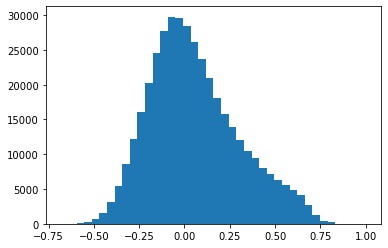

In [44]:
plt.hist( corr_array, bins=40)
plt.show

In [45]:
train_pts[point_index]

array([0.63662252, 0.08875569, 0.84278884, 2.29096432, 3.1778441 ,
       0.85054958, 0.18493975, 0.18389842, 1.40582237])

In [46]:
df0 = train_pts[:,0] - train_pts[point_index,0]
df1 = train_pts[:,1] - train_pts[point_index,1]
df2 = train_pts[:,2] - train_pts[point_index,2]
df3 = train_pts[:,3] - train_pts[point_index,3]
df4 = train_pts[:,4] - train_pts[point_index,4]
df5 = train_pts[:,5] - train_pts[point_index,5]
df6 = train_pts[:,6] - train_pts[point_index,6]
df7 = train_pts[:,7] - train_pts[point_index,7]
df8 = train_pts[:,8] - train_pts[point_index,8]
dr = np.sqrt( df0*df0 + df1*df1 + df2*df2 + df3*df3 + df4*df4 + df5*df5 + df6*df6 + df7*df7 + df8*df8)

In [47]:
df0.shape

(400000,)

In [48]:
corr_array.shape

(400000,)

<function matplotlib.pyplot.show(close=None, block=None)>

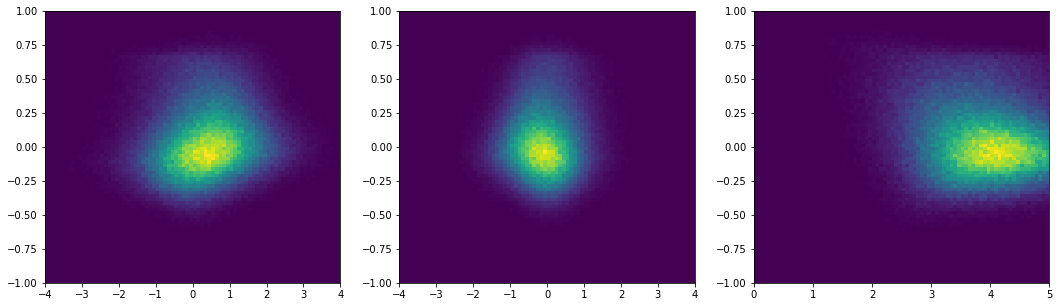

In [49]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))
ax[0].hist2d( df0, corr_array, bins=[80,80], range=([-4,4],[-1,1]))
ax[1].hist2d( df1, corr_array, bins=[80,80], range=([-4,4],[-1,1]))
ax[2].hist2d( dr, corr_array, bins=[80,80], range=([0,5],[-1,1]))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

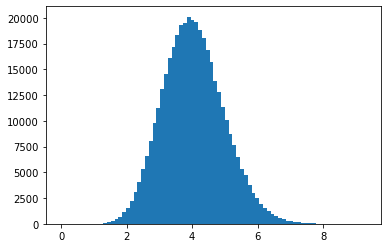

In [50]:
plt.hist( dr, bins=80 )
plt.show

## Save the output

In [51]:
output_filebase = 'bootstrap-9d-output-test1g-diagonal-cov'

In [52]:
with open( '%s.npy' % output_filebase, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)
    np.save(f, bootstrap_weights)
    np.save(f, of_weights[(of_niter-1),1,:])
    

In [53]:
train_pts.shape

(400000, 9)

In [54]:
train_det_pts

array([[ 0.64910039, -0.63233297, -1.00123783, ..., -0.57024762,
         0.92130529,  1.72289929],
       [ 2.66756839, -0.64595344,  0.02533432, ..., -0.01152962,
         0.35329218,  0.4283473 ],
       [ 0.34990981, -0.46009484, -1.04986207, ..., -0.7579209 ,
        -1.20488456,  1.68174696],
       ...,
       [ 4.00279437, -1.13541809,  0.46894264, ..., -0.01214985,
         1.05904471, -1.34922216],
       [ 1.88956769, -0.26134364, -2.09126211, ...,  0.40813824,
        -0.06379134,  0.14300572],
       [ 1.49925362,  0.32864772, -0.44394238, ..., -0.88046745,
         0.10846879,  1.45367238]])

In [55]:
true_det_pts

array([[ 0.91983886, -0.24768809,  0.49368736, ..., -0.27722815,
        -0.29716775,  0.62178448],
       [-0.28283786, -0.01099184, -1.11556339, ..., -0.98860564,
        -0.49657369,  0.95331484],
       [-0.5098855 ,  1.33322635,  0.89597126, ..., -0.93627508,
        -0.01284051, -1.02455739],
       ...,
       [ 0.17980611,  0.27428046,  0.94182933, ..., -0.09842768,
         0.36881845,  0.11448813],
       [-1.51804362,  0.002533  , -1.28321894, ..., -0.3968111 ,
         0.33836015, -2.25131216],
       [ 1.05329076, -0.42197621, -0.68638067, ...,  0.38485698,
        -0.55654437,  0.15331889]])

In [56]:
true_det_pts.shape

(40000, 9)

In [57]:
bootstrap_weights

array([[0.05825846, 0.00444955, 0.03938199, ..., 0.0105007 , 0.2651993 ,
        0.13181777],
       [0.08582669, 0.01145625, 0.01765387, ..., 0.00134041, 0.30778998,
        0.12308044],
       [0.10842548, 0.00644783, 0.04220739, ..., 0.00238085, 0.31157064,
        0.10876457],
       ...,
       [0.05609452, 0.0171862 , 0.02683219, ..., 0.00033051, 0.20904326,
        0.10039526],
       [0.07841862, 0.01780036, 0.02446106, ..., 0.01191623, 0.24608339,
        0.10663573],
       [0.07524089, 0.01588428, 0.02323137, ..., 0.00223302, 0.21525036,
        0.0911767 ]])

In [58]:
bootstrap_weights.shape

(50, 400000)

In [59]:
bootstrap_weights[:,2]

array([0.03938199, 0.01765387, 0.04220739, 0.03272454, 0.0192466 ,
       0.00920512, 0.00924671, 0.013429  , 0.00439362, 0.01334916,
       0.0080949 , 0.0214371 , 0.0118385 , 0.01582975, 0.01019064,
       0.01408821, 0.01913972, 0.03028987, 0.02240823, 0.00374529,
       0.00961018, 0.01709406, 0.01254841, 0.00914127, 0.00897986,
       0.01336789, 0.00625524, 0.0124944 , 0.01497462, 0.00594604,
       0.00596532, 0.01180277, 0.01398574, 0.01490927, 0.01155092,
       0.01288672, 0.04291177, 0.02685557, 0.02531888, 0.04608718,
       0.0218766 , 0.02661599, 0.02398701, 0.02963805, 0.02022839,
       0.02180864, 0.02623121, 0.02683219, 0.02446106, 0.02323137])

In [60]:
bootstrap_weights[:,5]

array([3.54310032e-03, 1.25394890e-03, 1.35946798e-03, 1.58974458e-03,
       9.72713460e-04, 2.08142470e-03, 1.19979610e-03, 6.53708866e-03,
       3.53512615e-02, 8.27675778e-03, 3.74434981e-03, 2.19516573e-03,
       1.45693729e-03, 8.23786110e-03, 3.29685397e-03, 2.61849468e-03,
       1.35515246e-03, 3.05665564e-03, 4.69971262e-03, 1.36548991e-03,
       9.02737316e-04, 6.67818997e-04, 1.31775474e-03, 9.52961491e-05,
       3.89392750e-04, 3.77127109e-03, 2.74361093e-02, 4.80241887e-03,
       7.03153783e-05, 2.33388110e-03, 1.08720106e-03, 1.03566302e-02,
       1.17300439e-03, 7.98497873e-04, 9.67720640e-04, 1.05598075e-02,
       3.65751260e-03, 3.30999447e-03, 1.68976421e-03, 3.01438477e-03,
       5.21053607e-03, 3.80109041e-03, 8.19153711e-03, 1.17768859e-02,
       7.11370539e-03, 3.13967769e-03, 7.98866211e-04, 1.17104268e-03,
       7.67722027e-03, 1.12409750e-02])

In [61]:
bootstrap_weights[:,6]

array([0.00184401, 0.00705796, 0.00252043, 0.00533658, 0.00455751,
       0.01033958, 0.00362211, 0.00171256, 0.00359901, 0.00259803,
       0.00178212, 0.00264783, 0.00194026, 0.00209337, 0.00581121,
       0.00373864, 0.00159009, 0.00434735, 0.00440593, 0.00688954,
       0.00329257, 0.00392492, 0.00464935, 0.00221781, 0.00220548,
       0.00140809, 0.00341072, 0.0026463 , 0.00322021, 0.00287743,
       0.00334357, 0.00271207, 0.00122955, 0.00089585, 0.00179981,
       0.00235519, 0.02206111, 0.00483207, 0.00240214, 0.00576607,
       0.00536954, 0.01209694, 0.00954513, 0.01118008, 0.0095085 ,
       0.00881629, 0.00688133, 0.00111489, 0.00114874, 0.00075638])

In [62]:
bootstrap_weights[:,7]

array([0.14867128, 0.17557439, 0.14686708, 0.13783488, 0.11644117,
       0.14543477, 0.11469147, 0.06765988, 0.02782716, 0.10910058,
       0.11478791, 0.06171246, 0.06553389, 0.13203514, 0.07276649,
       0.09054546, 0.11105075, 0.0475264 , 0.08627533, 0.11693641,
       0.07933147, 0.13860305, 0.08387545, 0.13153633, 0.25008181,
       0.11258549, 0.11086047, 0.06314708, 0.07862401, 0.14509508,
       0.12210543, 0.0986087 , 0.08506263, 0.09471177, 0.06151025,
       0.0504417 , 0.01712509, 0.14949538, 0.11847116, 0.95328474,
       0.21718733, 1.01877022, 0.78413379, 0.156611  , 0.21916948,
       0.13295019, 0.21713941, 0.12212127, 0.07006438, 0.08273965])

In [63]:
bootstrap_weights[49,:]

array([0.07524089, 0.01588428, 0.02323137, ..., 0.00223302, 0.21525036,
       0.0911767 ])

In [64]:
bootstrap_weights[48,:]

array([0.07841862, 0.01780036, 0.02446106, ..., 0.01191623, 0.24608339,
       0.10663573])

In [65]:
bootstrap_weights[47,:]

array([0.05609452, 0.0171862 , 0.02683219, ..., 0.00033051, 0.20904326,
       0.10039526])

In [66]:
bootstrap_weights[46,:]

array([0.10327581, 0.0176234 , 0.02623121, ..., 0.00145414, 0.22075036,
       0.10438258])